In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [3]:
quarter_df = pd.read_csv(r"C:\Users\spostma2\OneDrive - Louwman\Documents\School\EMM\Quarterly_London_crime.csv")
quarter_df

,LSOA Code,Quarter,LSOA Name,Borough,Year,ARSON AND CRIMINAL DAMAGE_rate,BURGLARY_rate,DRUG OFFENCES_rate,MISCELLANEOUS CRIMES AGAINST SOCIETY_rate,POSSESSION OF WEAPONS_rate,PUBLIC ORDER OFFENCES_rate,ROBBERY_rate,VEHICLE OFFENCES_rate,VIOLENCE AGAINST THE PERSON_rate,THEFT_rate,Median age mid-year,Male Population,Female Population,Total Population
0,E01000006,2011Q1,Barking and Dagenham 016A,Barking and Dagenham,2011,0.000000,2.310803,0.577701,0.00000,0.000000,0.000000,0.577701,3.466205,1.155402,3.466205,31.2,882.0,849.0,1731.0
1,E01000006,2011Q2,Barking and Dagenham 016A,Barking and Dagenham,2011,0.000000,2.310803,1.733102,0.00000,0.000000,0.577701,1.155402,4.621606,2.310803,0.577701,31.2,882.0,849.0,1731.0
2,E01000006,2011Q3,Barking and Dagenham 016A,Barking and Dagenham,2011,2.310803,2.310803,1.733102,0.00000,0.000000,0.577701,1.155402,2.888504,1.733102,1.733102,31.2,882.0,849.0,1731.0
3,E01000006,2011Q4,Barking and Dagenham 016A,Barking and Dagenham,2011,0.000000,2.310803,1.733102,0.00000,0.000000,0.577701,2.310803,5.777008,2.310803,1.155402,31.2,882.0,849.0,1731.0
4,E01000006,2012Q1,Barking and Dagenham 016A,Barking and Dagenham,2012,0.562114,2.810568,0.000000,0.00000,0.000000,0.562114,0.562114,3.934795,3.372681,0.000000,31.3,922.0,857.0,1779.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199515,E01035722,2019Q4,Westminster 024G,Westminster,2019,1.261034,2.101723,0.000000,0.00000,1.261034,0.420345,2.101723,2.101723,3.362757,4.623792,37.3,1145.0,1234.0,2379.0
199516,E01035722,2020Q1,Westminster 024G,Westminster,2020,0.000000,3.487358,0.871840,0.43592,0.000000,1.743679,0.435920,3.051439,5.231037,2.615519,36.8,1123.0,1171.0,2294.0
199517,E01035722,2020Q2,Westminster 024G,Westminster,2020,0.000000,1.743679,1.307759,0.00000,0.000000,0.435920,0.000000,1.307759,6.538797,0.871840,36.8,1123.0,1171.0,2294.0
199518,E01035722,2020Q3,Westminster 024G,Westminster,2020,1.743679,0.435920,2.615519,0.00000,0.435920,1.743679,0.000000,3.487358,3.487358,4.795118,36.8,1123.0,1171.0,2294.0


# Defining exceptionality
## Normalisation

In [4]:
global_mean = quarter_df['THEFT_rate'].mean()
global_std = quarter_df['THEFT_rate'].std()

quarter_df['theft_z'] = (quarter_df['THEFT_rate'] - global_mean) / global_std

## Setting threshold

In [5]:
threshold = 2
quarter_df['theft_exception'] = (quarter_df['theft_z'].abs() > threshold).astype(int)

### Extras

In [6]:
def label_runs(group):
    group = group.sort_values('Quarter')
    
    group['start_of_exception'] = ((group['theft_exception'] == 1) & 
                                   (group['theft_exception'].shift(1) != 1)).astype(int)
    
    group['end_of_exception'] = ((group['theft_exception'] == 0) & 
                                 (group['theft_exception'].shift(1) == 1)).astype(int)
    
    return group

quarter_df = quarter_df.groupby('LSOA Code').apply(label_runs).reset_index(drop=True)

C:\Users\spostma2\AppData\Local\Temp\ipykernel_18556\1622487910.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarter_df = quarter_df.groupby('LSOA Code').apply(label_runs).reset_index(drop=True)


In [7]:
quarter_df['run_id'] = quarter_df.groupby('LSOA Code')['start_of_exception'].cumsum()
quarter_df['run_id'] = quarter_df['run_id'].where(quarter_df['theft_exception']==1)

# Wouter's Beam Search

In [8]:
"""
The following code was adapted from W. Duivesteijn, T.C. van Dijk. (2021)
    Exceptional Gestalt Mining: Combining Magic Cards to Make Complex Coalitions Thrive. 
    In: Proceedings of the 8th Workshop on Machine Learning and Data Mining for Sports Analytics.
    Available from http://wwwis.win.tue.nl/~wouter/Publ/J05-EMM_DMKD.pdf
"""

# Package imports
import heapq
import numpy as np

# Classes
class BoundedPriorityQueue:
    """
    Used to store the <q> most promising subgroups
    Ensures uniqness
    Keeps a maximum size (throws away value with least quality)
    """

    def __init__(self, bound): 
        # Initializes empty queue with maximum length of <bound>
        self.values = []
        self.bound = bound
        self.entry_count = 0

    def add(self, element, quality, **adds): 
        # Adds <element> to the bounded priority queue if it is of sufficient quality
        new_entry = (quality, self.entry_count, element, adds)
        if (len(self.values) >= self.bound):
            heapq.heappushpop(self.values, new_entry)
        else:
            heapq.heappush(self.values, new_entry)

        self.entry_count += 1

    def get_values(self):
        # Returns elements in bounded priority queue in sorted order
        for (q, _, e, x) in sorted(self.values, reverse=True):
            yield (q, e, x)

    def show_contents(self):  
        # Prints contents of the bounded priority queue (used for debugging)
        print("show_contents")
        for (q, entry_count, e) in self.values:
            print(q, entry_count, e)

class Queue:
    """
    Used to store candidate solutions
    Ensures uniqness
    """

    def __init__(self): # Initializes empty queue
        self.items = []

    def is_empty(self): # Returns True if queue is empty, False otherwise
        return self.items == []

    def enqueue(self, item): # Adds <item> to queue if it is not already present
        if item not in self.items:
            self.items.insert(0, item)

    def dequeue(self): # Pulls one item from the queue
        return self.items.pop()

    def size(self): # Returns the number of items in the queue
        return len(self.items)

    def get_values(self): # Returns the queue (as a list)
        return self.items

    def add_all(self, iterable): # Adds all items in <iterable> to the queue, given they are not already present
        for item in iterable:
            self.enqueue(item)

    def clear(self): # Removes all items from the queue
        self.items.clear()
        
# Functions
def refine(desc, more):
    # Creates a copy of the seed <desc> and adds it to the new selector <more>
    # Used to prevent pointer issues with selectors
    copy = desc[:]
    copy.append(more)
    return copy

def as_string(desc):
    # Adds ' and ' to <desc> such that selectors are properly separated when the refine function is used
    return ' and '.join(desc)

def eta(seed, df, features, n_chunks = 5):
    # Returns a generator which includes all possible refinements of <seed> for the given <features> on dataset <df>
    # n_chunks refers to the number of possible splits we consider for numerical features
    
    print("eta ", seed)
    if seed != []:              #we only specify more on the elements that are still in the subset
        d_str = as_string(seed)
        ind = df.eval(d_str)
        df_sub = df.loc[ind, ]
    else:
        df_sub = df
    for f in features:
        if (df_sub[f].dtype == 'float64') or (df_sub[f].dtype == 'float32'): #get quantiles here instead of intervals for the case that data are very skewed
            column_data = df_sub[f]
            dat = np.sort(column_data)
            dat = dat[np.logical_not(np.isnan(dat))]
            for i in range(1,n_chunks+1): #determine the number of chunks you want to divide your data in
                x = np.percentile(dat,100/i) #
                candidate = "{} <= {}".format(f, x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {}".format(f, x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df_sub[f].dtype == 'object'):
            column_data = df_sub[f]
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df_sub[f].dtype == 'int64'):
            column_data = df_sub[f]
            dat = np.sort(column_data)
            dat = dat[np.logical_not(np.isnan(dat))]
            for i in range(1,n_chunks+1): #determine the number of chunks you want to divide your data in
                x = np.percentile(dat,100/i) #
                candidate = "{} <= {}".format(f, x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {}".format(f, x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df_sub[f].dtype == 'bool'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        else:
            assert False
            
def satisfies_all(desc, df, threshold=0.02):
    # Function used to check if subgroup with pattern <desc> is sufficiently big relative to its dataset <df>
    # A subgroup is sufficiently big if the proportion of data included in it exceeds <threshold>   
    d_str = as_string(desc)
    ind = df.eval(d_str)
    return sum(ind) >= len(df) * 0.02 

def eval_quality(desc, df, target):
    # Function used to calculate the solution's WRAcc
    sub_group = df[df.eval(as_string(desc))] 
    prop_p_sg = len(sub_group[sub_group[target]==1])/len(sub_group)
    prop_p_df = len(df[df[target]==1])/len(df)
    wracc = ((len(sub_group)/len(df))**1) * (prop_p_sg - prop_p_df) #for WRAcc a=1
    return wracc

def EMM(w, d, q, catch_all_description, df, features, target, n_chunks=5, ensure_diversity = False):
    """
    w - width of beam, i.e. the max number of results in the beam
    d - num levels, i.e. how many attributes are considered
    q - max results, i.e. max number of results output by the algorithm
    eta - a function that receives a description and returns all possible refinements
    satisfies_all - a function that receives a description and verifies wheather it satisfies some requirements as needed
    eval_quality - returns a quality for a given description. This should be comparable to qualities of other descriptions
    catch_all_description - the equivalent of True, or all, as that the whole dataset shall match
    df - dataframe of mined dataset
    features - features in scope
    target - column name of target attribute in df
    """
    
    # Initialize variables
    resultSet = BoundedPriorityQueue(q) # Set of results, can contain results from multiple levels
    candidateQueue = Queue() # Set of candidate solutions to consider adding to the ResultSet
    candidateQueue.enqueue(catch_all_description) # Set of results on a particular level
    error = 0.00001 # Allowed error margin (due to floating point error) when comparing the quality of solutions

    # Perform BeamSearch for <d> levels
    for level in range(d):
        print("level : ", level)
        
        # Initialize this level's beam
        beam = BoundedPriorityQueue(w)

        # Go over all rules generated on previous level, or 'empty' rule if level = 0 
        for seed in candidateQueue.get_values():
            print("    seed : ", seed)
            
            # Start by evaluating the quality of the seed
            if seed != []:
                seed_quality = eval_quality(seed, df, target)
            else:
                seed_quality = 99

            # For all refinements created by eta function on descriptions (i.e features), which can be different types of columns
            # eta(seed) reads the dataset given certain seed (i.e. already created rules) and looks at new descriptions
            for desc in eta(seed, df, features, n_chunks):

                # Check if the subgroup contains at least x% of data, proceed if yes
                if satisfies_all(desc, df):

                    # Calculate the new solution's quality
                    quality = eval_quality(desc, df, target)
                    
                    # Ensure diversity by forcing difference in quality when compared to its seed
                    # if <ensure_diversity> is set to True. Principle is based on:
                    # Van Leeuwen, M., & Knobbe, A. (2012), Diverse subgroup set discovery.
                    # Data Mining and Knowledge Discovery, 25(2), 208-242.
                    if ensure_diversity:
                        if quality < (seed_quality * 1-error) or quality > (seed_quality * 1+error) :
                            resultSet.add(desc, quality)
                            beam.add(desc, quality)
                    else:
                        resultSet.add(desc, quality)
                        beam.add(desc, quality)

        # When all candidates for a search level have been explored, 
        # the contents of the beam are moved into candidateQueue, to generate next level candidates
        candidateQueue = Queue()
        candidateQueue.add_all(desc for (_, desc, _) in beam.get_values())
        
    # Return the <resultSet> once the BeamSearch algorithm has completed
    return resultSet

### Little Preprocessing before EMM implementation

In [9]:
df = quarter_df.copy()
rename_map = {
    'ARSON AND CRIMINAL DAMAGE_rate': 'arson_damage',
    'BURGLARY_rate': 'burglary',
    'DRUG OFFENCES_rate': 'drugs',
    'MISCELLANEOUS CRIMES AGAINST SOCIETY_rate': 'misc_crime',
    'POSSESSION OF WEAPONS_rate': 'weapons',
    'PUBLIC ORDER OFFENCES_rate': 'public_order',
    'ROBBERY_rate': 'robbery',
    'THEFT_rate': 'theft',
    'VEHICLE OFFENCES_rate': 'vehicle',
    'VIOLENCE AGAINST THE PERSON_rate': 'violence',
    'Male Population': 'pop_male',
    'Female Population': 'pop_female',
    'Total Population': 'pop_total',
    'Median age mid-year': 'age_median'
}

df = df.rename(columns=rename_map)
df

,LSOA Code,Quarter,LSOA Name,Borough,Year,arson_damage,burglary,drugs,misc_crime,weapons,...,theft,age_median,pop_male,pop_female,pop_total,theft_z,theft_exception,start_of_exception,end_of_exception,run_id
0,E01000006,2011Q1,Barking and Dagenham 016A,Barking and Dagenham,2011,0.000000,2.310803,0.577701,0.00000,0.000000,...,3.466205,31.2,882.0,849.0,1731.0,-0.120242,0,0,0,NaN
1,E01000006,2011Q2,Barking and Dagenham 016A,Barking and Dagenham,2011,0.000000,2.310803,1.733102,0.00000,0.000000,...,0.577701,31.2,882.0,849.0,1731.0,-0.237938,0,0,0,NaN
2,E01000006,2011Q3,Barking and Dagenham 016A,Barking and Dagenham,2011,2.310803,2.310803,1.733102,0.00000,0.000000,...,1.733102,31.2,882.0,849.0,1731.0,-0.190860,0,0,0,NaN
3,E01000006,2011Q4,Barking and Dagenham 016A,Barking and Dagenham,2011,0.000000,2.310803,1.733102,0.00000,0.000000,...,1.155402,31.2,882.0,849.0,1731.0,-0.214399,0,0,0,NaN
4,E01000006,2012Q1,Barking and Dagenham 016A,Barking and Dagenham,2012,0.562114,2.810568,0.000000,0.00000,0.000000,...,0.000000,31.3,922.0,857.0,1779.0,-0.261477,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199515,E01035722,2019Q4,Westminster 024G,Westminster,2019,1.261034,2.101723,0.000000,0.00000,1.261034,...,4.623792,37.3,1145.0,1234.0,2379.0,-0.073075,0,0,0,NaN
199516,E01035722,2020Q1,Westminster 024G,Westminster,2020,0.000000,3.487358,0.871840,0.43592,0.000000,...,2.615519,36.8,1123.0,1171.0,2294.0,-0.154905,0,0,0,NaN
199517,E01035722,2020Q2,Westminster 024G,Westminster,2020,0.000000,1.743679,1.307759,0.00000,0.000000,...,0.871840,36.8,1123.0,1171.0,2294.0,-0.225953,0,0,0,NaN
199518,E01035722,2020Q3,Westminster 024G,Westminster,2020,1.743679,0.435920,2.615519,0.00000,0.435920,...,4.795118,36.8,1123.0,1171.0,2294.0,-0.066094,0,0,0,NaN


In [10]:
borough_type_map = {
    # Central
    "Westminster": "Central_Boroughs",
    "Camden": "Central_Boroughs",
    "Islington": "Central_Boroughs",
    "Kensington and Chelsea": "Central_Boroughs",

    # Inner East / Gentrifying
    "Hackney": "Inner_East_Gentrifying",
    "Tower Hamlets": "Inner_East_Gentrifying",
    "Southwark": "Inner_East_Gentrifying",
    "Lambeth": "Inner_East_Gentrifying",

    # Inner West Affluent
    "Hammersmith and Fulham": "Inner_West_Affluent",
    "Wandsworth": "Inner_West_Affluent",

    # Inner Mixed
    "Haringey": "Inner_North_Mixed",
    "Lewisham": "Inner_South_Mixed",

    # East Regeneration
    "Newham": "East_Regeneration",
    "Barking and Dagenham": "East_Regeneration",
    "Waltham Forest": "East_Regeneration",

    # Outer East Suburban
    "Redbridge": "Outer_East_Suburban",
    "Havering": "Outer_East_Suburban",
    "Bexley": "Outer_East_Suburban",

    # Outer North Suburban
    "Barnet": "Outer_North_Suburban",
    "Enfield": "Outer_North_Suburban",
    "Harrow": "Outer_North_Suburban",
    "Hillingdon": "Outer_North_Suburban",

    # Outer South Suburban
    "Croydon": "Outer_South_Suburban",
    "Bromley": "Outer_South_Suburban",
    "Sutton": "Outer_South_Suburban",

    # Outer West Mixed / Heathrow corridor
    "Brent": "Outer_West_Mixed",
    "Ealing": "Outer_West_Mixed",
    "Hounslow": "Outer_West_Mixed",

    # South-West Affluent Riverside
    "Richmond upon Thames": "Riverside_Affluent_SouthWest",
    "Kingston upon Thames": "Riverside_Affluent_SouthWest",
    "Merton": "Riverside_Affluent_SouthWest",

    # South-Central Urban / Regeneration
    "Greenwich": "South_Central_Urban"
}

df["Borough_Type"] = df["Borough"].map(borough_type_map)

In [11]:
df.columns

Index(['LSOA Code', 'Quarter', 'LSOA Name', 'Borough', 'Year', 'arson_damage',
       'burglary', 'drugs', 'misc_crime', 'weapons', 'public_order', 'robbery',
       'vehicle', 'violence', 'theft', 'age_median', 'pop_male', 'pop_female',
       'pop_total', 'theft_z', 'theft_exception', 'start_of_exception',
       'end_of_exception', 'run_id', 'Borough_Type'],
      dtype='object')

In [ ]:
def make_quantile_cuts(df, col, qlist=[20,40,60,80], min_support_frac=0.02):
    vals = []
    clean = df[col].dropna().values
    for p in qlist:
        cut = np.percentile(clean, p)
        vals.append(cut)
    conds = []
    for cut in sorted(set(vals)):
        conds.append(f"{col} <= {cut}")
        conds.append(f"{col} > {cut}")
    out = []
    for c in conds:
        mask = apply_rule_list(df, [c])
        if mask.sum() >= len(df) * min_support_frac:
            out.append(c)
    return out

def make_categorical_conds(df, col, min_support_frac=0.02):
    vals = df[col].dropna().unique()
    out = []
    for v in vals:
        c1 = f"{col} == '{v}'"
        c2 = f"{col} != '{v}'"
        if apply_rule_list(df, [c1]).sum() >= len(df)*min_support_frac:
            out.append(c1)
        if apply_rule_list(df, [c2]).sum() >= len(df)*min_support_frac:
            out.append(c2)
    return out

def candidate_pool_from_features(df, features, numeric_qs=[20,40,60,80], min_support_frac=0.02):
    pool = {}
    for f in features:
        if df[f].dtype.kind in "fiu": 
            pool[f] = make_quantile_cuts(df, f, numeric_qs, min_support_frac)
        else:
            pool[f] = make_categorical_conds(df, f, min_support_frac)

    flat = []
    for lst in pool.values():
        flat.extend(lst)
    return flat

def dt_seeds(df, features, target, max_depth=2, min_samples_leaf=50):
    X = df[features].copy()

    X = pd.get_dummies(X, drop_first=True)
    y = df[target].fillna(0).astype(int)
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    clf.fit(X.fillna(0), y)

    from sklearn.tree import _tree
    tree = clf.tree_
    feature_names = X.columns.tolist()
    paths = []
    def recurse(node, path):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            # left
            recurse(tree.children_left[node], path + [f"{name} <= {threshold}"])
            recurse(tree.children_right[node], path + [f"{name} > {threshold}"])
        else:
            paths.append(path)
    recurse(0, [])
    return paths


In [67]:
target = 'theft_exception'
features = [
        'Borough', 'age_median', 'pop_male', 'pop_female',
       'pop_total', 'Borough_Type'
]
candidates = candidate_pool_from_features(df, features)

results = []
for rule in tqdm(candidates):
    mask = apply_rule_list(df, [rule])
    wracc = compute_wracc(df, mask, target_col=target)
    results.append({'rule': rule, 'wracc': wracc, 'coverage': mask.mean()})

rules_df = pd.DataFrame(results).sort_values('wracc', ascending=False)
rules_df.head(10)

100%|██████████| 119/119 [00:01<00:00, 117.27it/s]


,rule,wracc,coverage
105,Borough_Type == 'Central_Boroughs',0.004459,0.096231
79,pop_female <= 768.0,0.004426,0.201143
65,age_median <= 33.800000000000004,0.003607,0.408841
81,pop_female <= 843.0,0.003462,0.402727
87,pop_total <= 1503.0,0.003443,0.200120
63,age_median <= 31.8,0.003333,0.200441
67,age_median <= 35.9,0.003152,0.604551
71,pop_male <= 726.0,0.002794,0.200281
61,Borough == 'Westminster',0.002402,0.024659
83,pop_female <= 907.0,0.002106,0.602265


## Beam search implementation

Quarterly data

In [69]:
features = [
        'age_median', 'pop_male', 'pop_female',
       'pop_total', 'Borough_Type'
]

target = 'theft_exception'

catch_all_description = []

# Search per quarter
results_per_quarter = {}


#First baseline (w/o time dimension)
baseline_df = df.copy()

baseline_result = EMM(
    w=5,             # beam width
    d=3,             # depth
    q=10,            # max results
    catch_all_description=catch_all_description,
    df=baseline_df,
    features=features,
    target=target,
    n_chunks=5,
    ensure_diversity=True
)

results_per_quarter = {"Baseline": list(baseline_result.get_values())}
for q in df['Quarter'].unique():
    q_df = df[df['Quarter'] == q].copy()
    

    if len(q_df) < 50:
        continue
    
    resultSet = EMM(
        w=5,             # beam width
        d=3,             # depth
        q=10,            # max results
        catch_all_description=catch_all_description,
        df=q_df,
        features=features,
        target=target,
        n_chunks=5,
        ensure_diversity=True
    )
    
    results_per_quarter[q] = list(resultSet.get_values())

for q, res in results_per_quarter.items():
    print(f"--- Quarter: {q} ---")
    for quality, desc, extra in res:
        print(f"WRAcc: {quality:.4f}, Subgroup: {desc}")

level :  0
    seed :  []
eta  []
level :  1
    seed :  ['age_median <= 33.1']
eta  ['age_median <= 33.1']
    seed :  ['pop_female <= 821.0']
eta  ['pop_female <= 821.0']
    seed :  ['pop_female <= 791.0']
eta  ['pop_female <= 791.0']
    seed :  ['pop_female <= 768.0']
eta  ['pop_female <= 768.0']
    seed :  ["Borough_Type == 'Central_Boroughs'"]
eta  ["Borough_Type == 'Central_Boroughs'"]
level :  2
    seed :  ['pop_female <= 768.0', "Borough_Type != 'Outer_North_Suburban'"]
eta  ['pop_female <= 768.0', "Borough_Type != 'Outer_North_Suburban'"]
    seed :  ['pop_female <= 791.0', "Borough_Type != 'Riverside_Affluent_SouthWest'"]
eta  ['pop_female <= 791.0', "Borough_Type != 'Riverside_Affluent_SouthWest'"]
    seed :  ['pop_female <= 821.0', 'age_median <= 35.800000000000004']
eta  ['pop_female <= 821.0', 'age_median <= 35.800000000000004']
    seed :  ['pop_female <= 768.0', "Borough_Type != 'Riverside_Affluent_SouthWest'"]
eta  ['pop_female <= 768.0', "Borough_Type != 'Riversi

Full dataset

# WRAcc time-series

In [70]:
import re
import numpy as np

def canonicalize_rule(rule_list):
    feats = {}

    pattern = re.compile(r"(.+?)\s*(<=|>=|>|<|==|!=)\s*(.+)")

    for cond in rule_list:
        m = pattern.match(cond)
        if not m:
            continue

        feat, op, val = m.groups()
        val = val.strip()

        try:
            val = float(val)
        except:
            pass

        if feat not in feats:
            feats[feat] = []

        feats[feat].append((op, val))

    canonical = []

    for feat, constraints in feats.items():
        le = [v for o, v in constraints if o == "<="]
        ge = [v for o, v in constraints if o == ">="]
        gt = [v for o, v in constraints if o == ">"]
        lt = [v for o, v in constraints if o == "<"]
        eq = [v for o, v in constraints if o == "=="]
        neq = [v for o, v in constraints if o == "!="]

        if eq:
            canonical.append(f"{feat} == {eq[0]}")
            continue

        if le:
            canonical.append(f"{feat} <= {min(le)}")

        if ge:
            canonical.append(f"{feat} >= {max(ge)}")

        if gt:
            canonical.append(f"{feat} > {max(gt)}")

        if lt:
            canonical.append(f"{feat} < {min(lt)}")

        if neq:
            canonical.append(f"{feat} != {','.join(sorted(map(str,set(neq))))}")

    return " AND ".join(sorted(canonical))

In [71]:
records = []

for quarter, results in results_per_quarter.items():
    for quality, desc, extra in results:
        canonical = canonicalize_rule(desc)
        records.append({
            "quarter": quarter,
            "WRAcc": quality,
            "subgroup_raw": desc,
            "subgroup_str": canonical
        })

emm_df = pd.DataFrame(records)

In [72]:
emm_df

,quarter,WRAcc,subgroup_raw,subgroup_str
0,Baseline,0.004705,"[pop_female <= 791.0, Borough_Type != 'Riversi...","Borough_Type != 'Outer_North_Suburban','Rivers..."
1,Baseline,0.004682,"[pop_female <= 768.0, Borough_Type != 'Riversi...","Borough_Type != 'Outer_North_Suburban','Rivers..."
2,Baseline,0.004682,"[pop_female <= 768.0, Borough_Type != 'Outer_N...","Borough_Type != 'Outer_North_Suburban','Rivers..."
3,Baseline,0.004670,"[pop_female <= 791.0, age_median <= 35.5, Boro...",Borough_Type != 'Riverside_Affluent_SouthWest'...
4,Baseline,0.004660,"[pop_female <= 791.0, Borough_Type != 'Riversi...",Borough_Type != 'Riverside_Affluent_SouthWest'...
...,...,...,...,...
405,2020Q4,0.002773,"[age_median <= 33.5, Borough_Type != 'Inner_No...","Borough_Type != 'Inner_North_Mixed','Outer_Nor..."
406,2020Q4,0.002756,"[age_median <= 33.5, Borough_Type != 'Outer_No...","Borough_Type != 'Inner_West_Affluent','Outer_N..."
407,2020Q4,0.002756,"[age_median <= 33.5, Borough_Type != 'Inner_We...","Borough_Type != 'Inner_West_Affluent','Outer_N..."
408,2020Q4,0.002740,"[age_median <= 33.5, Borough_Type != 'Outer_No...",Borough_Type != 'Outer_North_Suburban' AND age...


In [73]:
emm_df = (
    emm_df.groupby(["quarter", "subgroup_str"])
    .agg({
        "WRAcc": "mean",
        "subgroup_raw": "first"  # keep one representative raw subgroup for WRAcc recalculation
    })
    .reset_index()
)
emm_df

,quarter,subgroup_str,WRAcc,subgroup_raw
0,2011Q1,Borough_Type != 'Inner_North_Mixed' AND age_me...,0.004714,"[pop_female <= 793.3333333333335, age_median <..."
1,2011Q1,Borough_Type != 'Inner_North_Mixed' AND age_me...,0.004700,"[pop_female <= 793.3333333333335, age_median <..."
2,2011Q1,Borough_Type != 'Inner_West_Affluent' AND age_...,0.004593,"[pop_female <= 793.3333333333335, age_median <..."
3,2011Q1,Borough_Type != 'Outer_North_Suburban' AND age...,0.004842,"[pop_female <= 793.3333333333335, age_median <..."
4,2011Q1,Borough_Type != 'Outer_North_Suburban' AND age...,0.004659,"[pop_female <= 765.0, age_median <= 33.9, Boro..."
...,...,...,...,...
325,Baseline,"Borough_Type != 'Outer_North_Suburban','Rivers...",0.004705,"[pop_female <= 791.0, Borough_Type != 'Riversi..."
326,Baseline,Borough_Type != 'Riverside_Affluent_SouthWest'...,0.004660,"[pop_female <= 791.0, Borough_Type != 'Riversi..."
327,Baseline,Borough_Type != 'Riverside_Affluent_SouthWest'...,0.004670,"[pop_female <= 791.0, age_median <= 35.5, Boro..."
328,Baseline,Borough_Type != 'Riverside_Affluent_SouthWest'...,0.004607,"[pop_female <= 821.0, age_median <= 35.8000000..."


In [74]:
import numpy as np

def apply_rule_list(df, rule_list):
    """
    rule_list: list of strings, e.g.
    ['pop_female <= 793.333', 'age_median <= 32.4', "Borough_Type != 'Outer_North_Suburban'"]
    Returns: boolean mask for df
    """
    mask = np.ones(len(df), dtype=bool)
    
    for cond in rule_list:
        # remove spaces around operators
        cond = cond.strip()
        
        # numeric <= or >=
        if "<=" in cond:
            col, val = cond.split("<=")
            mask &= df[col.strip()] <= float(val.strip())
        elif ">=" in cond:
            col, val = cond.split(">=")
            mask &= df[col.strip()] >= float(val.strip())
        elif "<" in cond:
            col, val = cond.split("<")
            mask &= df[col.strip()] < float(val.strip())
        elif ">" in cond:
            col, val = cond.split(">")
            mask &= df[col.strip()] > float(val.strip())
        # categorical == or !=
        elif "!=" in cond:
            col, val = cond.split("!=")
            mask &= df[col.strip()] != val.strip().strip("'").strip('"')
        elif "==" in cond:
            col, val = cond.split("==")
            mask &= df[col.strip()] == val.strip().strip("'").strip('"')
        else:
            raise ValueError(f"Condition not recognized: {cond}")
    
    return mask

In [75]:
def compute_wracc(df, mask, target_col="theft_exception"):
    g = len(df)
    sg = mask.sum()
    if sg == 0:
        return 0
    p = df[target_col].mean()
    p_sub = df.loc[mask, target_col].mean()
    return (sg / g) * (p_sub - p)

# example applying to emm_df
recomputed_wracc = []
for i, row in emm_df.iterrows():
    quarter = row['quarter']
    rule_list = row['subgroup_raw']
    if quarter == "Baseline":
        dfq = df.copy()  # baseline uses full data
    else:
        dfq = df[df['Quarter'] == quarter]
    mask = apply_rule_list(dfq, rule_list)
    score = compute_wracc(dfq, mask, target_col="theft_exception")
    recomputed_wracc.append(score)

emm_df['WRAcc_recomputed'] = recomputed_wracc
emm_df

,quarter,subgroup_str,WRAcc,subgroup_raw,WRAcc_recomputed
0,2011Q1,Borough_Type != 'Inner_North_Mixed' AND age_me...,0.004714,"[pop_female <= 793.3333333333335, age_median <...",0.004714
1,2011Q1,Borough_Type != 'Inner_North_Mixed' AND age_me...,0.004700,"[pop_female <= 793.3333333333335, age_median <...",0.004700
2,2011Q1,Borough_Type != 'Inner_West_Affluent' AND age_...,0.004593,"[pop_female <= 793.3333333333335, age_median <...",0.004593
3,2011Q1,Borough_Type != 'Outer_North_Suburban' AND age...,0.004842,"[pop_female <= 793.3333333333335, age_median <...",0.004842
4,2011Q1,Borough_Type != 'Outer_North_Suburban' AND age...,0.004659,"[pop_female <= 765.0, age_median <= 33.9, Boro...",0.004659
...,...,...,...,...,...
325,Baseline,"Borough_Type != 'Outer_North_Suburban','Rivers...",0.004705,"[pop_female <= 791.0, Borough_Type != 'Riversi...",0.004705
326,Baseline,Borough_Type != 'Riverside_Affluent_SouthWest'...,0.004660,"[pop_female <= 791.0, Borough_Type != 'Riversi...",0.004660
327,Baseline,Borough_Type != 'Riverside_Affluent_SouthWest'...,0.004670,"[pop_female <= 791.0, age_median <= 35.5, Boro...",0.004670
328,Baseline,Borough_Type != 'Riverside_Affluent_SouthWest'...,0.004607,"[pop_female <= 821.0, age_median <= 35.8000000...",0.004607


In [76]:
emm_df.sort_values(by=["subgroup_str", "quarter"], inplace=True)

In [77]:
wracc_ts = emm_df.pivot_table(
    index='subgroup_str',
    columns='quarter',
    values='WRAcc',
    fill_value=0
)

## Evaluation metrics

In [78]:
quarter_cols = [c for c in wracc_ts.columns if c not in ["Baseline"]]


wracc_ts['persistence'] = (wracc_ts > 0).sum(axis=1) / 40
wracc_ts['emergence'] = wracc_ts.diff(axis=1).clip(lower=0).sum(axis=1)
wracc_ts['volatility'] = wracc_ts.std(axis=1)

# Statistics & Visualisation

In [79]:
def classify_quarter_change(row):
    status = []
    prev_wracc = 0
    for q in wracc_ts.columns[:-3]:  # exclude metrics columns
        current_wracc = row[q]
        if current_wracc > 0 and prev_wracc == 0:
            status.append('emergent')
        elif current_wracc > 0 and prev_wracc > 0:
            status.append('persistent')
        elif current_wracc == 0 and prev_wracc > 0:
            status.append('declining')
        else:
            status.append('inactive')
        prev_wracc = current_wracc
    return status

wracc_ts['quarter_status'] = wracc_ts.apply(classify_quarter_change, axis=1)

In [80]:
from collections import Counter

feature_counter = Counter()
for desc in emm_df['subgroup_str']:
    features = [f.split()[0] for f in desc.split(" AND ")]
    feature_counter.update(features)

feature_counter

Counter({'Borough_Type': 305,
         'pop_female': 238,
         'age_median': 154,
         'pop_male': 8,
         'pop_total': 3})

In [81]:
wracc_ts.columns = wracc_ts.columns.astype(str)

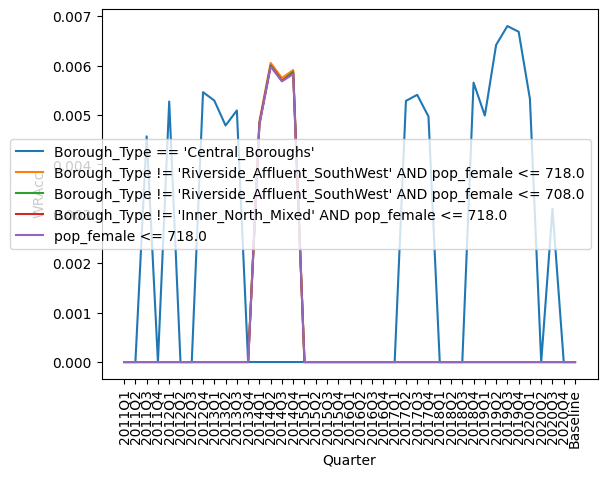

In [82]:
quarter_cols = [c for c in wracc_ts.columns if c not in ["persistence", "emergence", "volatility", "quarter_status"]]
top_groups = wracc_ts.sort_values("volatility", ascending=False).head(5).index

for subgroup in top_groups:
    row = wracc_ts.loc[subgroup]
    plt.plot(quarter_cols, row[quarter_cols].values, label=subgroup)

plt.xticks(rotation=90)
plt.ylabel("WRAcc")
plt.xlabel("Quarter")
plt.legend()
plt.show()


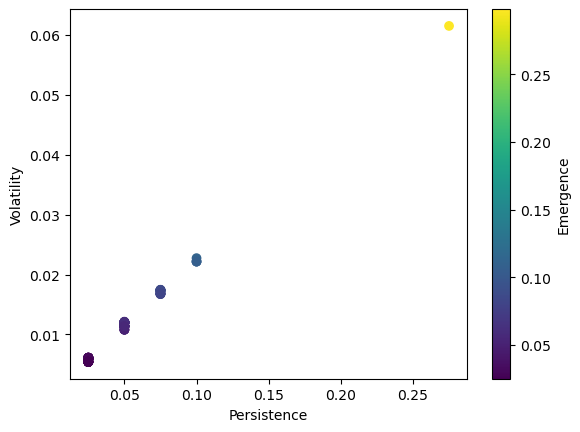

In [166]:
plt.scatter(wracc_ts['persistence'], wracc_ts['volatility'], c=wracc_ts['emergence'], cmap='viridis')
plt.colorbar(label='Emergence')
plt.xlabel('Persistence')
plt.ylabel('Volatility')
plt.show()

Global WRAcc baseline: 0.0040


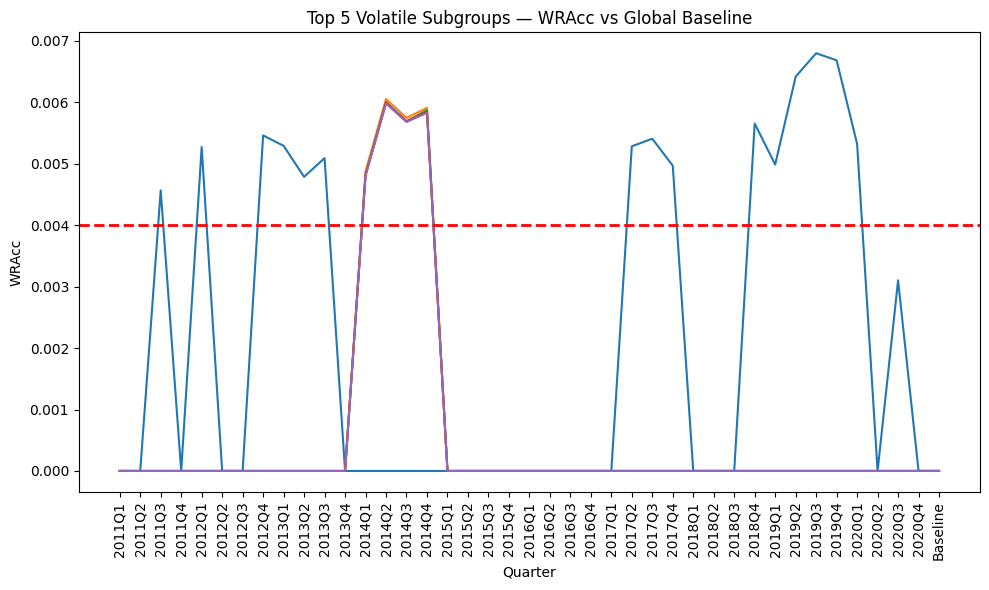

In [87]:
import matplotlib.pyplot as plt

quarter_cols = [c for c in wracc_ts.columns if c not in ["persistence", "emergence", "volatility", "quarter_status"]]
top_groups = wracc_ts.sort_values("volatility", ascending=False).head(5).index

# --- Compute global baseline ---
global_baseline = 0.004
print(f"Global WRAcc baseline: {global_baseline:.4f}")

# --- Plot WRAcc curves with global baseline ---
plt.figure(figsize=(10, 6))
for subgroup in top_groups:
    row = wracc_ts.loc[subgroup]
    plt.plot(quarter_cols, row[quarter_cols].values, label=subgroup)

# Add global baseline line
plt.axhline(y=global_baseline, color='red', linestyle='--', linewidth=2, label=f'Global baseline ({global_baseline:.3f})')

plt.xticks(rotation=90)
plt.ylabel("WRAcc")
plt.xlabel("Quarter")
plt.title("Top 5 Volatile Subgroups — WRAcc vs Global Baseline")
#plt.legend()
plt.tight_layout()
plt.show()
